In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
#%tensorflow_version 2.x
import pandas as pd
import numpy as np

import librosa
import librosa.display as lid

import matplotlib.pyplot as plt
%matplotlib inline

import time

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1D, Flatten, Dense, Input, MaxPooling1D, Dropout, GaussianNoise, AveragePooling1D
from tensorflow.keras.regularizers import l1, l2
import tensorflow as tf

import multiprocessing as mp

TensorFlow 2.x selected.


In [3]:
librosa.__version__

'0.6.3'

In [0]:
def multi_reader(path):
    df = pd.read_csv(path, header=None)
    return df

In [0]:
#path = "drive/My Drive/audio/"
path="../data/audio"


pool = mp.Pool(2)
fede, fede_n = pool.map(multi_reader, [path+"Federico.csv", path+"Federico_new.csv"])
pool.close()
pool.join()




pool = mp.Pool(6)
ricc_si, ricc_no, ricc_forse, ricc_si_n, ricc_no_n, ricc_forse_n = pool.map(multi_reader, 
                                                                            [path+"Riccardo/Riccardo_sì.csv", 
                                                                             path+"Riccardo/Riccardo_no.csv",
                                                                             path+"Riccardo/Riccardo_forse.csv",
                                                                             path+"Riccardo/Riccardo_sì2.csv",
                                                                             path+"Riccardo/Riccardo_no2.csv",
                                                                             path+"Riccardo/Riccardo_forse2.csv"])


pool.close()
pool.join()

ricc_si = pd.concat((ricc_si.drop(0,axis=1), ricc_si_n.drop(0,axis=1)))
ricc_no = pd.concat((ricc_no.drop(0,axis=1), ricc_no_n.drop(0,axis=1)))
ricc_forse = pd.concat((ricc_forse.drop(0,axis=1), ricc_forse_n.drop(0,axis=1)))


pool = mp.Pool(6)
pk_si, pk_no, pk_forse, pk_si_n, pk_no_n, pk_forse_n = pool.map(multi_reader, 
                                                                [path+"Pranav/Pranav_si.csv", 
                                                                 path+"Pranav/Pranav_no.csv",
                                                                 path+"Pranav/Pranav_forse.csv",
                                                                 path+"Pranav/Pranav_si_noisy.csv",
                                                                 path+"Pranav/Pranav_no_noisy.csv",
                                                                 path+"Pranav/Pranav_forse_noisy.csv"])


pool.close()
pool.join()


pk_si = pd.concat((pk_si.drop(0,axis=1), pk_si_n.drop(0,axis=1)))
pk_no = pd.concat((pk_no.drop(0,axis=1), pk_no_n.drop(0,axis=1)))
pk_forse = pd.concat((pk_forse.drop(0,axis=1), pk_forse_n.drop(0,axis=1)))

In [0]:
fede = pd.concat((fede,fede_n))

In [0]:
fede_si = fede[fede[0]=='sì'].drop(0,axis=1)
fede_no = fede[fede[0]=='no'].drop(0,axis=1)
fede_forse = fede[fede[0]=='forse'].drop(0,axis=1)

In [0]:
fede_si["what"] = "si"
fede_no["what"] = "no"
fede_forse["what"] = "forse"

ricc_si["what"] = "si"
ricc_no["what"] = "no"
ricc_forse["what"] = "forse"

pk_si["what"] = "si"
pk_no["what"] = "no"
pk_forse["what"] = "forse"

In [0]:
ricc = pd.concat((ricc_si, ricc_no, ricc_forse))
ricc["is_ricc"] = 1
pk = pd.concat((pk_si, pk_no, pk_forse))
pk["is_pk"] = 1
fede = pd.concat((fede_si, fede_no, fede_forse))
fede["is_fede"] = 1

data_set = pd.concat((ricc, pk, fede), sort=False).fillna(0)

In [0]:
hk_si = pd.read_csv(path + 'extraTesting/Harshita_si.csv', header=None).drop(0, axis=1)
hk_no = pd.read_csv(path + 'extraTesting/Harshita_no.csv', header=None).drop(0,axis=1)
hk_forse = pd.read_csv(path + 'extraTesting/Harshita_forse.csv', header=None).drop(0,axis=1)
hk_caso = pd.read_csv(path + 'extraTesting/Harshita_caso.csv', header=None).drop(0,axis=1)

In [11]:
print(data_set.shape)
data_set.head()

(981, 88204)


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,88165,88166,88167,88168,88169,88170,88171,88172,88173,88174,88175,88176,88177,88178,88179,88180,88181,88182,88183,88184,88185,88186,88187,88188,88189,88190,88191,88192,88193,88194,88195,88196,88197,88198,88199,88200,what,is_ricc,is_pk,is_fede
0,-0.001343,-0.001373,-0.001434,-0.001526,-0.001678,-0.001709,-0.001709,-0.001953,-0.002350,-0.002655,-0.002747,-0.002747,-0.002991,-0.003265,-0.003479,-0.003693,-0.003723,-0.003845,-0.004089,-0.004395,-0.004730,-0.004761,-0.004822,-0.005005,-0.005310,-0.005463,-0.005463,-0.005524,-0.005493,-0.005341,-0.005157,-0.005188,-0.005280,-0.005432,-0.005371,-0.005280,-0.005127,-0.005127,-0.005157,-0.005096,...,-0.000275,-0.000244,-0.000122,0.000061,0.000214,0.000305,0.000305,0.000214,0.000153,0.000153,0.000153,0.000244,0.000305,0.000336,0.000366,0.000275,0.000122,0.000000,0.000000,-0.000031,0.000092,0.000214,0.000183,0.000122,0.000122,0.000214,0.000275,0.000275,0.000397,0.000336,0.000244,0.000153,0.000061,0.000000,0.000031,0.000122,si,1.0,0.0,0.0
1,0.002136,0.001770,0.001404,0.000977,0.000671,0.000397,-0.000031,-0.000336,-0.000397,-0.000275,-0.000031,0.000061,0.000061,-0.000153,-0.000610,-0.000977,-0.001160,-0.001434,-0.001892,-0.002441,-0.002838,-0.003082,-0.003387,-0.003601,-0.003876,-0.004211,-0.004517,-0.004791,-0.004913,-0.004974,-0.005096,-0.005432,-0.005768,-0.005859,-0.005737,-0.005859,-0.005920,-0.006104,-0.006287,-0.006348,...,0.000336,0.000397,0.000427,0.000366,0.000275,0.000336,0.000397,0.000366,0.000244,0.000214,0.000336,0.000305,0.000244,0.000336,0.000366,0.000336,0.000336,0.000366,0.000366,0.000214,0.000183,0.000275,0.000153,0.000031,0.000031,0.000000,-0.000031,-0.000061,0.000031,0.000092,0.000122,0.000000,-0.000092,-0.000183,-0.000305,-0.000366,si,1.0,0.0,0.0
2,-0.008911,-0.009491,-0.009979,-0.010498,-0.010986,-0.011353,-0.011780,-0.012177,-0.012512,-0.012756,-0.012939,-0.012970,-0.012756,-0.012482,-0.012177,-0.011780,-0.011322,-0.010895,-0.010498,-0.010162,-0.009827,-0.009491,-0.009155,-0.008820,-0.008698,-0.008545,-0.008240,-0.007874,-0.007446,-0.007019,-0.006470,-0.005890,-0.005096,-0.004272,-0.003418,-0.002533,-0.001740,-0.001038,-0.000275,0.000366,...,0.000732,0.000580,0.000366,0.000153,-0.000061,-0.000275,-0.000488,-0.000610,-0.000610,-0.000519,-0.000549,-0.000702,-0.000885,-0.001190,-0.001526,-0.001923,-0.002197,-0.002441,-0.002655,-0.002808,-0.002930,-0.002930,-0.002869,-0.002808,-0.002808,-0.003052,-0.003204,-0.003540,-0.003998,-0.004364,-0.004700,-0.004913,-0.004974,-0.005035,-0.004944,-0.004730,si,1.0,0.0,0.0
3,-0.005829,-0.005646,-0.005280,-0.004852,-0.004425,-0.004028,-0.003693,-0.003326,-0.002960,-0.002563,-0.002045,-0.001434,-0.000793,-0.000092,0.000610,0.001282,0.002014,0.002655,0.003204,0.003662,0.003937,0.004059,0.003967,0.003937,0.003998,0.004150,0.004303,0.004486,0.004761,0.005035,0.005280,0.005402,0.005524,0.005524,0.005615,0.005737,0.005981,0.006195,0.006409,0.006622,...,0.000763,0.001007,0.001404,0.001740,0.001587,0.001099,0.000732,0.000275,-0.000427,-0.001099,-0.001984,-0.002991,-0.003357,-0.002991,-0.002380,-0.001678,-0.000854,-0.000153,0.000031,-0.000031,0.000153,0.000610,0.000977,0.001221,0.001617,0.002411,0.002716,0.002441,0.002533,0.002441,0.001678,0.000763,0.000397,0.000366,0.000336,0.000031,si,1.0,0.0,0.0
4,-0.008179,-0.008362,-0.008453,-0.008514,-0.008392,-0.008209,-0.008118,-0.008118,-0.008240,-0.008392,-0.008545,-0.008575,-0.008514,-0.008423,-0.008331,-0.008209,-0.007935,-0.007751,-0.007721,-0.007690,-0.007660,-0.007599,-0.007568,-0.007477,-0.007324,-0.007080,-0.006836,-0.006348,-0.005615,-0.004944,-0.004333,-0.003906,-0.003540,-0.003235,-0.002777,-0.002228,-0.001770,-0.001526,-0.001312,-0.001190,...,-0.000275,-0.000305,-0.000366,-0.000397,-0.000336,-0.000336,-0.000336,-0.000275,-0.000244,-0.000214,-0.000214,-0.000122,-0.000061,-0.000061,0.000000,-0.000031,0.000000,0.000031,0.000061,0.000092,0.000092,0.000092,0.000153,0.000153,0.0001

In [0]:
train, test = train_test_split(data_set, test_size=0.3)

In [13]:
X_train = train.drop(['what', 'is_fede','is_ricc','is_pk'],axis=1).values.reshape(-1,88200,1)
X_test = test.drop(['what', 'is_fede','is_ricc','is_pk'],axis=1).values.reshape(-1,88200,1)
print(X_train.shape)
print(X_test.shape)

(686, 88200, 1)
(295, 88200, 1)


In [14]:
print("Max value:", max(np.max(X_train), np.max(X_train)))
print("Min value:", min(np.min(X_train), np.min(X_train)))

Max value: 0.999969482421875
Min value: -1.0


In [0]:
y_what_train = train['what'].values.reshape(-1,1)
y_what_test = test['what'].values.reshape(-1,1)

y_is_fede_train = train['is_fede'].values#.reshape(-1,1)
y_is_ricc_train = train['is_ricc'].values#.reshape(-1,1)
y_is_pk_train = train['is_pk'].values#.reshape(-1,1)

y_is_fede_test = test['is_fede'].values#.reshape(-1,1)
y_is_ricc_test = test['is_ricc'].values#.reshape(-1,1)
y_is_pk_test = test['is_pk'].values#.reshape(-1,1)

In [16]:
what_encoder = OneHotEncoder()
print(what_encoder.fit_transform(np.array(['si','no','forse']).reshape(-1,1)).toarray())

#forse = [1,0,0]
#no = [0,1,0]
#si = [0,0,1]

y_what_train = what_encoder.transform(y_what_train).toarray()
y_what_test = what_encoder.transform(y_what_test).toarray()

[[0. 0. 1.]
 [0. 1. 0.]
 [1. 0. 0.]]


## Feature extraction for simpler model

In [0]:
def energy(input):
    return np.sum((input*1.0)**2, keepdims=True)

def sdev(input):
    return np.std(input, keepdims=True)

def aavg(input):
    return np.mean(np.abs(input), keepdims=True)

def extract_feature(X, sample_rate=44100):
    X = X.reshape(sample_rate*2,)
    stft = np.abs(librosa.stft(X))
    mfccs = np.mean(librosa.feature.mfcc(y=X*1.0, sr=sample_rate, n_mfcc=40).T,axis=0)
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
    mel = np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)
    ene = energy(X)
    sd = sdev(X)
    avg = aavg(X)
    return np.concatenate((mfccs,chroma,mel,contrast,tonnetz,ene,sd,avg))

In [18]:
%%time
X_train_features = np.array(list(map(extract_feature, X_train)))
X_test_features = np.array(list(map(extract_feature, X_test)))

CPU times: user 6min 41s, sys: 2min 4s, total: 8min 46s
Wall time: 6min 25s


## Simple model

In [0]:
inp = Input(shape=(X_train_features.shape[1],))

x_what = Dense(256, activation='relu')(inp)
x_what = Dense(256, activation='relu')(x_what)

out_what = Dense(3, activation='softmax', name='what')(x_what)

x_who_r = Dense(256, activation='relu')(inp)
x_who_r = Dense(256, activation='relu')(x_who_r)

out_who_r = Dense(1, activation='sigmoid', name='riccardo')(x_who_r)

x_who_p = Dense(256, activation='relu')(inp)
x_who_p = Dense(256, activation='relu')(x_who_p)

out_who_p = Dense(1, activation='sigmoid', name='pranav')(x_who_p)

x_who_f = Dense(256, activation='relu')(inp)
x_who_f = Dense(256, activation='relu')(x_who_f)

out_who_f = Dense(1, activation='sigmoid', name='federico')(x_who_f)

model = Model(inp, [out_what,
                    out_who_r,
                    out_who_f,
                    out_who_p])

losses = {
    "what": "categorical_crossentropy",
    "riccardo": "binary_crossentropy",
    "pranav": "binary_crossentropy",
    "federico": "binary_crossentropy"
}

model.compile(loss=losses,
             optimizer='Adam',
             metrics=['accuracy'])

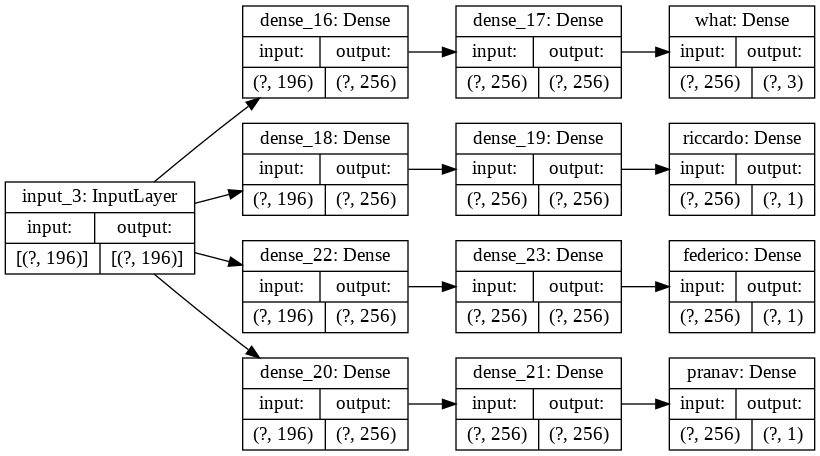

In [38]:
#Horizontal
tf.keras.utils.plot_model(model, 'model_basic_h.png', show_layer_names=True, show_shapes=True, dpi=96, rankdir='LR')

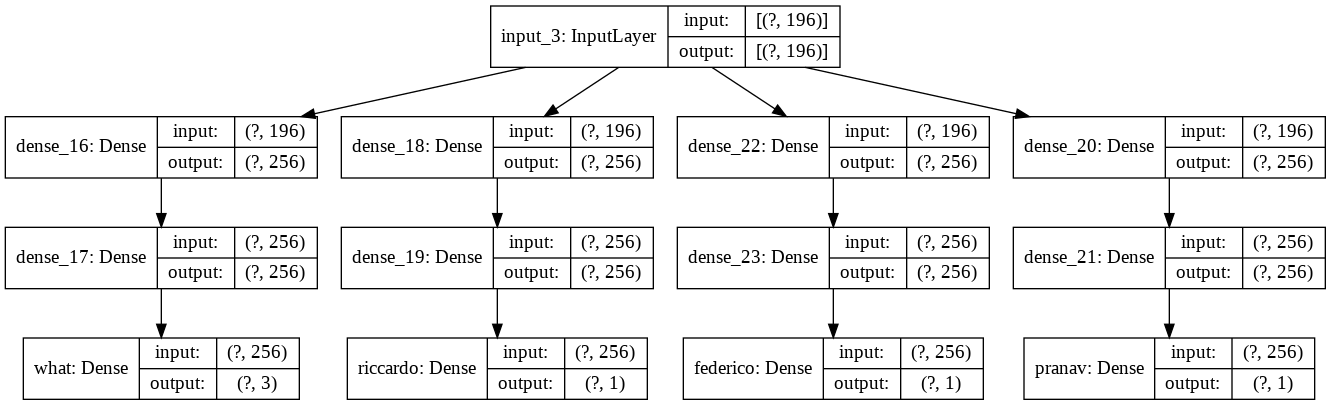

In [39]:
#vertical
tf.keras.utils.plot_model(model, 'model_basic.png',show_layer_names=True, show_shapes=True, dpi=96, rankdir='TB')

In [40]:
history = model.fit(X_train_features, [y_what_train,y_is_ricc_train, 
                              y_is_fede_train, y_is_pk_train], 
                    epochs=50, batch_size=32,
                    validation_data=(X_test_features, [y_what_test,y_is_ricc_test, 
                                              y_is_fede_test, y_is_pk_test]))

Train on 686 samples, validate on 295 samples
Epoch 1/50
686/686 [==============================] - 2s 3ms/sample - loss: 42.5670 - what_loss: 21.4428 - riccardo_loss: 12.4835 - federico_loss: 1.9232 - pranav_loss: 6.0429 - what_accuracy: 0.3965 - riccardo_accuracy: 0.6050 - federico_accuracy: 0.8673 - pranav_accuracy: 0.7026 - val_loss: 16.8190 - val_what_loss: 9.5399 - val_riccardo_loss: 5.5538 - val_federico_loss: 0.0469 - val_pranav_loss: 1.8850 - val_what_accuracy: 0.3525 - val_riccardo_accuracy: 0.5797 - val_federico_accuracy: 0.9864 - val_pranav_accuracy: 0.7966
Epoch 2/50
686/686 [==============================] - 0s 375us/sample - loss: 5.9056 - what_loss: 3.0817 - riccardo_loss: 1.9043 - federico_loss: 0.1357 - pranav_loss: 0.6605 - what_accuracy: 0.6370 - riccardo_accuracy: 0.7420 - federico_accuracy: 0.9840 - pranav_accuracy: 0.8805 - val_loss: 3.5326 - val_what_loss: 1.6058 - val_riccardo_loss: 0.8643 - val_federico_loss: 0.8039 - val_pranav_loss: 0.2157 - val_what_accurac

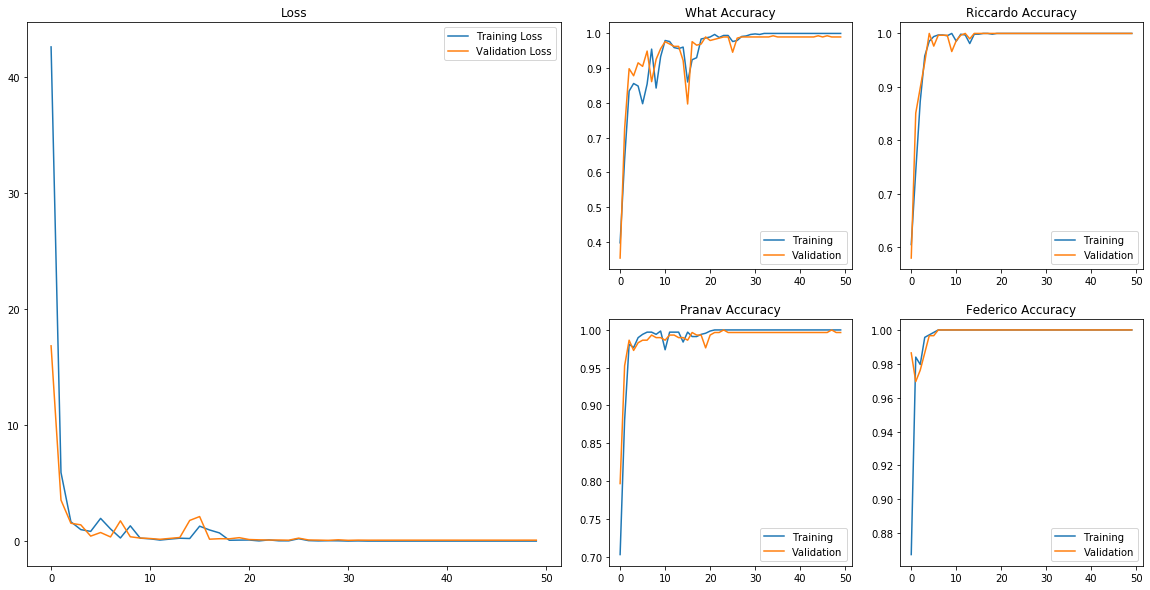

In [41]:
plt.figure(figsize=(20,10))

ax0 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

ax1 = plt.subplot2grid((2, 4), (0, 2))
plt.plot(history.history['what_accuracy'])
plt.plot(history.history['val_what_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('What Accuracy')


ax1 = plt.subplot2grid((2, 4), (1, 2))
plt.plot(history.history['pranav_accuracy'])
plt.plot(history.history['val_pranav_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Pranav Accuracy')


ax1 = plt.subplot2grid((2, 4), (0, 3))
plt.plot(history.history['riccardo_accuracy'])
plt.plot(history.history['val_riccardo_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Riccardo Accuracy')


ax1 = plt.subplot2grid((2, 4), (1, 3))
plt.plot(history.history['federico_accuracy'])
plt.plot(history.history['val_federico_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Federico Accuracy')
plt.show()

In [0]:
def predict_nn(model, X, rate=88200, threshold=0.95):
    #X = np.array(X).reshape(-1,rate,1).astype('float32')
    y = model.predict(X)

    what = list(map(lambda x: np.argmax(x) if x[np.argmax(x)] > 0.8 else -1, 
                  y[0]))
    what_what = {0:'Forse',1:'No',2:'Si',-1:'Non Capisco'}
    print(list(map(lambda x: what_what[x], what)))

    who = list(map(lambda x: np.argmax(x) if x[np.argmax(x)] > 0.8 else -1, 
                 np.hstack((y[1],y[2], y[3]))))
    person = {0:'Riccardo',1:'Federico',2:'Pranav',-1:'Unknown'}
    who_person = list(map(lambda x: person[x], who)) 
    print(who_person)

In [0]:
hk_no = np.array(list(map(extract_feature, hk_no.values)))
hk_si = np.array(list(map(extract_feature, hk_si.values)))
hk_forse = np.array(list(map(extract_feature, hk_forse.values)))
hk_caso = np.array(list(map(extract_feature, hk_caso.values)))

In [0]:
noemi = pd.read_csv(path+'Noemi.csv', header=None).drop(0, axis=1)
noemi = np.array(list(map(extract_feature, noemi.values)))

In [43]:
predict_nn(model, hk_no)

['No', 'No', 'Forse', 'No', 'Non Capisco', 'Si']
['Pranav', 'Unknown', 'Pranav', 'Pranav', 'Pranav', 'Pranav']


In [44]:
predict_nn(model, hk_si)

['Forse', 'Forse', 'Forse', 'Si']
['Pranav', 'Pranav', 'Pranav', 'Unknown']


In [45]:
predict_nn(model, hk_forse)

['Forse', 'Si', 'Forse', 'Non Capisco', 'Forse', 'Si']
['Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav']


In [46]:
predict_nn(model, hk_caso)

['Si', 'Si', 'Non Capisco', 'Forse', 'Si', 'Si', 'Si']
['Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav']


In [47]:
predict_nn(model, noemi)

['Si', 'No', 'No']
['Federico', 'Federico', 'Federico']


In [0]:
model.save('no_cnn_model.h5')

# Total Neural network


In [0]:
drop_out_rate=0.1
regularizer_weigth = 0.001
gaussina_sd = 0.05

input_tensor = Input(shape=(88200,1), name="AudioInput")

x = Conv1D(8, 11, padding='valid', activation='relu', 
           strides=1, name="Conv1")(input_tensor)
x = MaxPooling1D(10, name="MaxPool1")(x)
x = Dropout(drop_out_rate,name="FirstDropout")(x)
x = GaussianNoise(gaussina_sd,name="GaussianNoise")(x) #active only on training

x_what = Conv1D(16, 7, padding='valid', activation='relu', 
                strides=1, name="ConvWhat1")(x)
x_what = MaxPooling1D(10,name="MaxWhat1")(x_what)
x_what = Conv1D(16, 7, padding='valid', activation='relu', 
                strides=1, name="ConvWhat2")(x_what)
x_what = MaxPooling1D(10, name="MaxWhat2")(x_what)
x_what = Flatten(name="FlattenWhat")(x_what)

#x_what = GaussianNoise(gaussina_sd)(x_what)
x_what = Dense(256, activation='relu', name="FCWhat1")(x_what)
x_what = Dropout(drop_out_rate,name="DropWhat1")(x_what)
x_what = Dense(128, activation='relu',name="FCWhat2")(x_what)
x_what = Dropout(drop_out_rate, name="DropWhat2")(x_what)
output_tensor_what = Dense(3, activation='softmax',name="what")(x_what)


x_who = Conv1D(8, 11, padding='valid', activation='relu', 
               strides=1,name="ConvWho1")(x)
x_who = MaxPooling1D(10, name="MaxWho1")(x_who)
x_who = Dropout(drop_out_rate, name="DropWho1")(x_who)

x_who_r = Conv1D(16, 7, padding='valid', activation='relu', 
                 strides=1, name="ConvWhoR1")(x_who)
x_who_r = MaxPooling1D(10, name="MaxWhoR1")(x_who_r)
x_who_r = Conv1D(16, 7, padding='valid', activation='relu', 
                 strides=1, name="ConvWhoR2")(x_who_r)
x_who_r = MaxPooling1D(10, name="MaxWhoR2")(x_who_r)
x_who_r = Flatten(name="FlattenWhoR")(x_who_r)

x_who_r = Dense(256, activation='relu', name="FCWhoR1")(x_who_r)
x_who_r = Dropout(drop_out_rate, name="DropWhoR1")(x_who_r)
x_who_r = Dense(128, activation='relu', name="FCWhoR2")(x_who_r)
x_who_r = Dropout(drop_out_rate, name="DropWhoR2")(x_who_r)
output_tensor_who_r = Dense(1, activation='sigmoid', name="riccardo")(x_who_r)

x_who_f = Conv1D(16, 7, padding='valid', activation='relu', 
                 strides=1, name="ConvWhoF1")(x_who)
x_who_f = MaxPooling1D(10, name="MaxWhoF1")(x_who_f)
x_who_f = Conv1D(16, 7, padding='valid', activation='relu', 
                 strides=1, name="ConvWhoF2")(x_who_f)
x_who_f = MaxPooling1D(10, name="MaxWhoF2")(x_who_f)
x_who_f = Flatten(name="FlattenWhoF")(x_who_f)

x_who_f = Dense(256, activation='relu', name="FCWhoF1")(x_who_f)
x_who_f = Dropout(drop_out_rate,name="DropWhoF1")(x_who_f)
x_who_f = Dense(128, activation='relu', name="FCWhoF2")(x_who_f)
x_who_f = Dropout(drop_out_rate,name="DropWhoF2")(x_who_f)
output_tensor_who_f = Dense(1, activation='sigmoid', name="federico")(x_who_f)

x_who_p = Conv1D(16, 7, padding='valid', activation='relu', 
                 strides=1, name="ConvWhoP1")(x_who)
x_who_p = MaxPooling1D(10, name="MaxWhoP1")(x_who_p)
x_who_p = Conv1D(16, 7, padding='valid', activation='relu', 
                 strides=1, name="ConvWhoP2")(x_who_p)
x_who_p = MaxPooling1D(10, name="MaxWhoP2")(x_who_p)
x_who_p = Flatten(name="MaxWhoP")(x_who_p)

x_who_p = Dense(256, activation='relu', name="FCWhoP1")(x_who_p)
x_who_p = Dropout(drop_out_rate, name="DropWhoP1")(x_who_p)
x_who_p = Dense(128, activation='relu', name="FCWhoP2")(x_who_p)
x_who_p = Dropout(drop_out_rate,name="DropWhoP2")(x_who_p)
output_tensor_who_p = Dense(1, activation='sigmoid', name="pranav")(x_who_p)

model = Model(input_tensor, [output_tensor_what,
                             output_tensor_who_r,
                             output_tensor_who_f,
                             output_tensor_who_p])

losses = {
    "what": "categorical_crossentropy",
    "riccardo": "binary_crossentropy",
    "pranav": "binary_crossentropy",
    "federico": "binary_crossentropy"
}

model.compile(loss=losses,
             optimizer=tf.keras.optimizers.SGD(),
             metrics=['accuracy'])

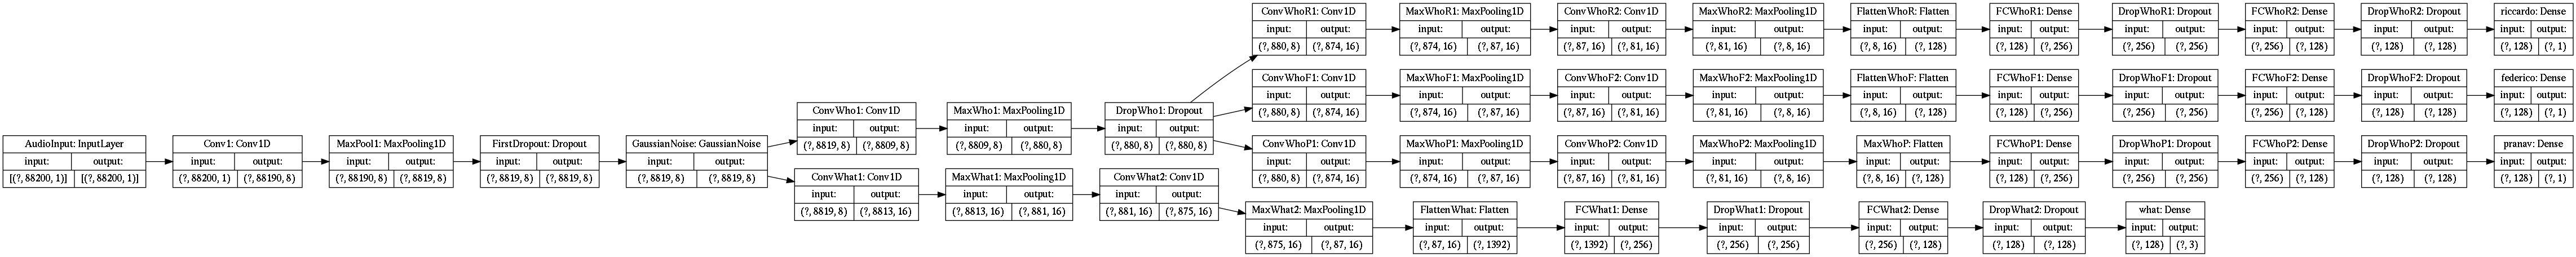

In [0]:
#Horizontal
tf.keras.utils.plot_model(model, 'model_h.png', show_layer_names=True, show_shapes=True, dpi=96, rankdir='LR')

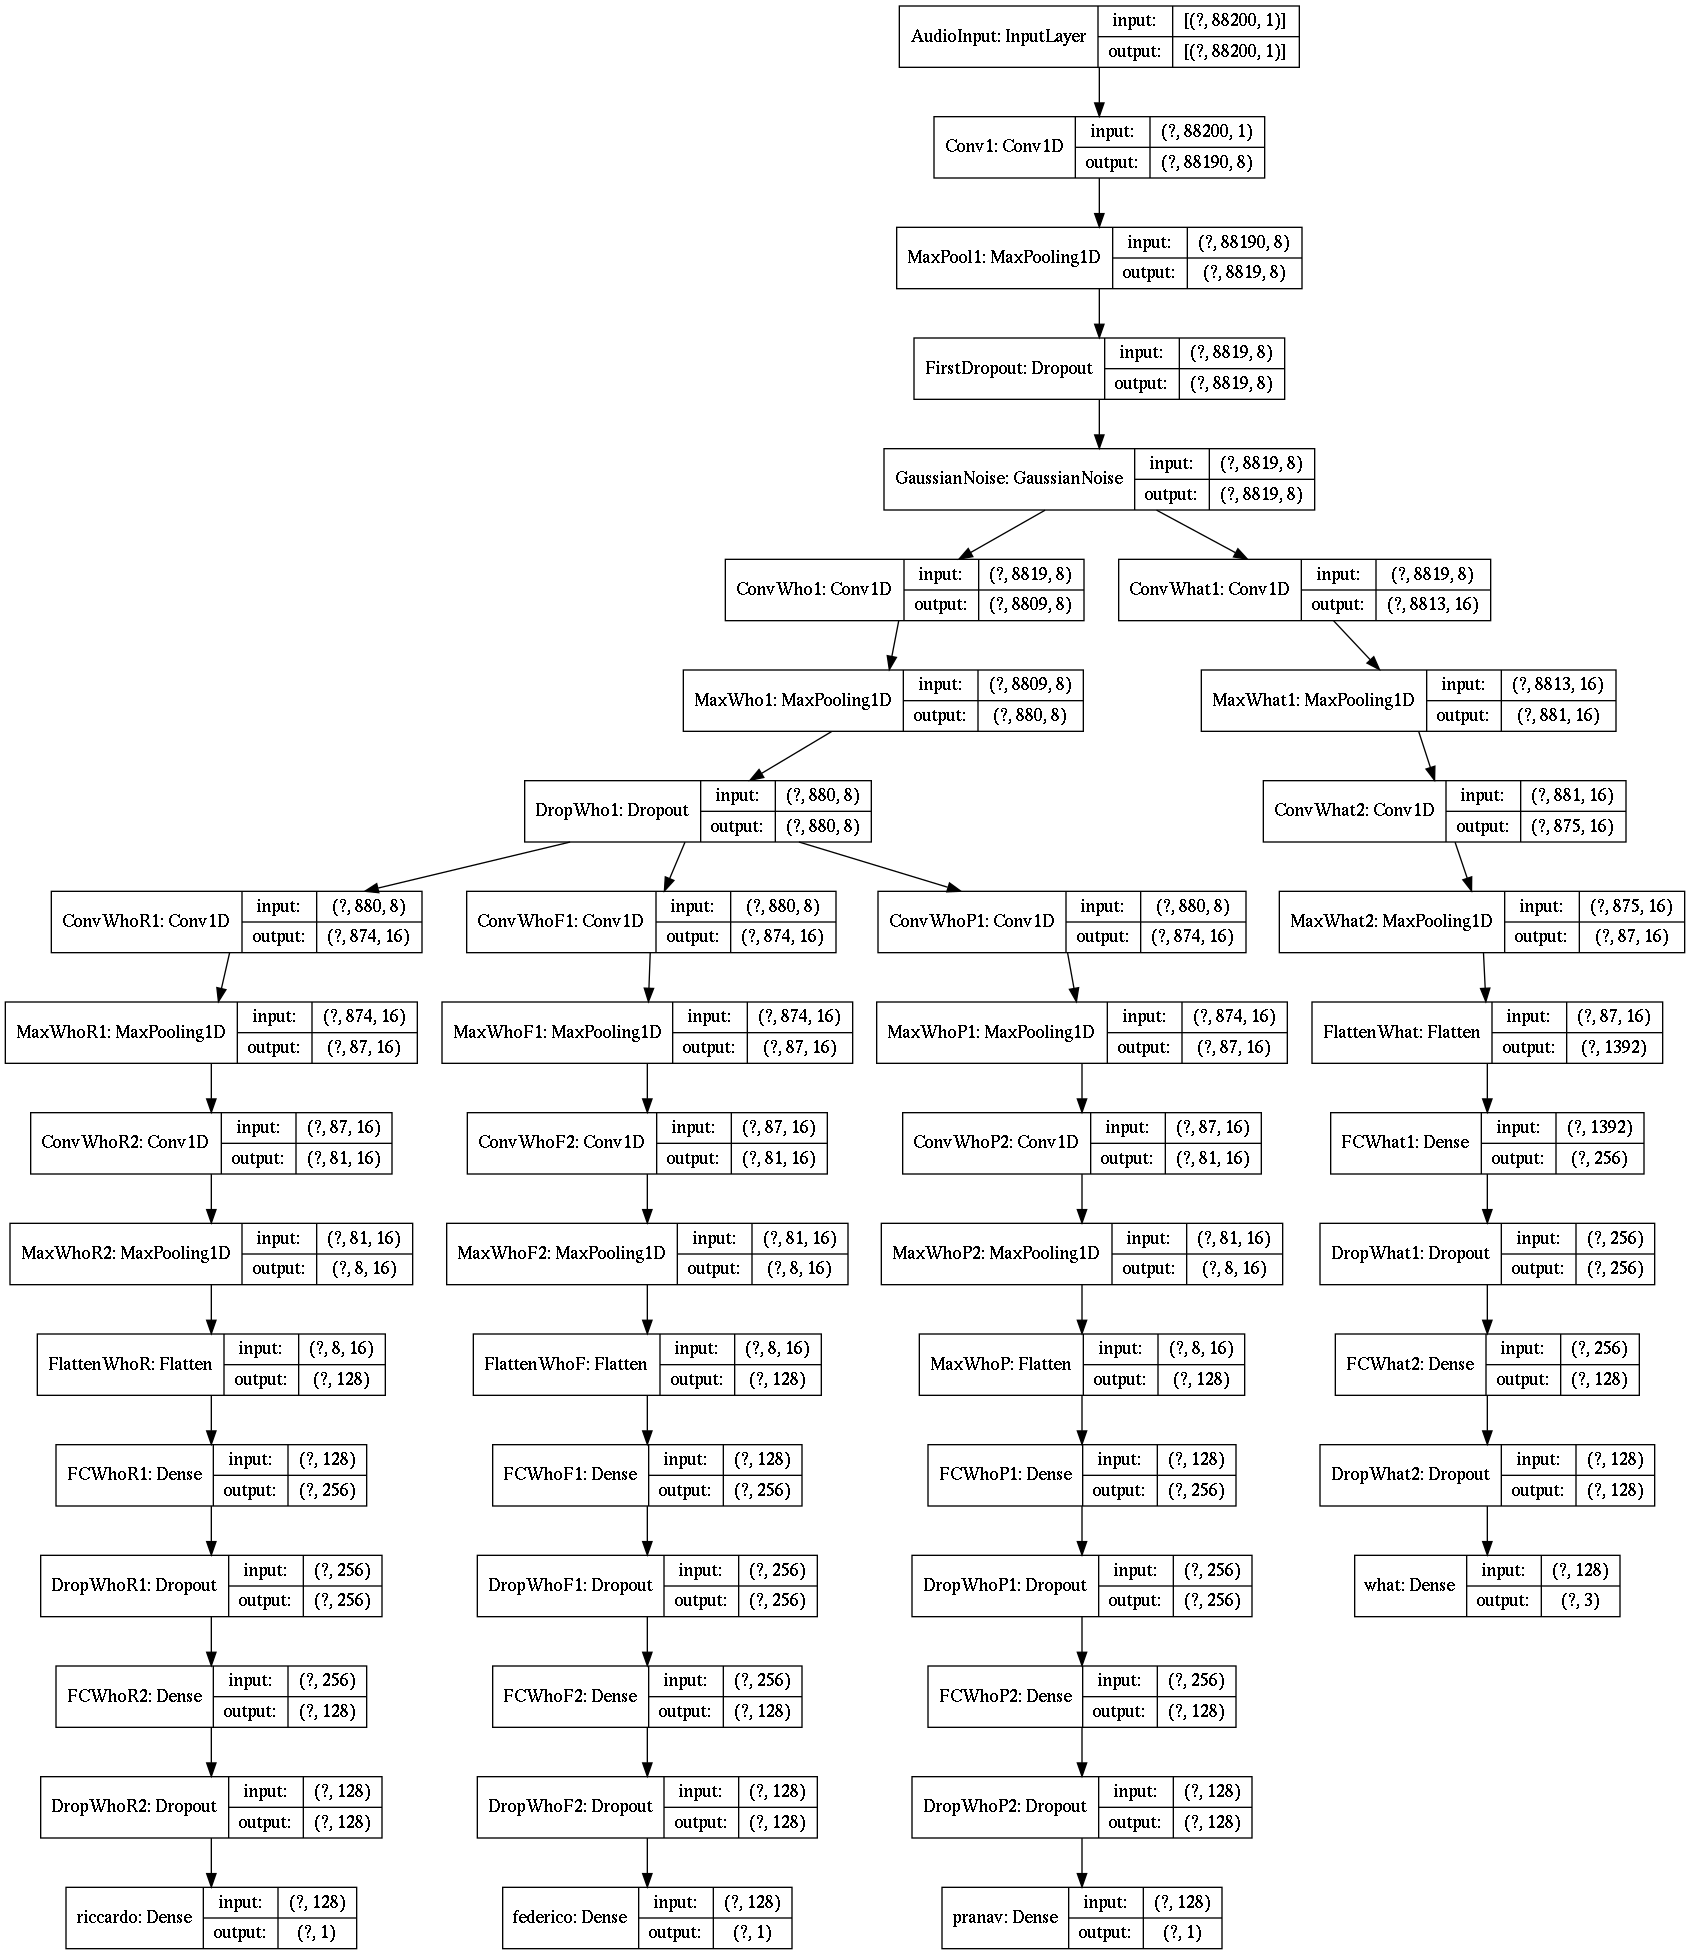

In [0]:
#vertical
tf.keras.utils.plot_model(model, show_layer_names=True, show_shapes=True, dpi=96, rankdir='TB')

In [0]:
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(patience=5, verbose=1, 
                                                  min_lr=1e-5, factor=0.8),
             tf.keras.callbacks.EarlyStopping(patience=100, verbose=1, restore_best_weights=True)]
history = model.fit(X_train, [y_what_train,y_is_ricc_train, 
                              y_is_fede_train, y_is_pk_train], 
                    epochs=200, batch_size=32,
                    callbacks=callbacks,
                    validation_data=(X_test, [y_what_test,y_is_ricc_test, 
                                              y_is_fede_test, y_is_pk_test]))

Train on 686 samples, validate on 295 samples
Epoch 1/200
686/686 [==============================] - 13s 19ms/sample - loss: 3.1626 - what_loss: 1.0990 - riccardo_loss: 0.6865 - federico_loss: 0.6872 - pranav_loss: 0.6889 - what_accuracy: 0.3309 - riccardo_accuracy: 0.5948 - federico_accuracy: 0.6501 - pranav_accuracy: 0.5394 - val_loss: 3.1374 - val_what_loss: 1.0994 - val_riccardo_loss: 0.6799 - val_federico_loss: 0.6858 - val_pranav_loss: 0.6733 - val_what_accuracy: 0.3051 - val_riccardo_accuracy: 0.6576 - val_federico_accuracy: 0.6339 - val_pranav_accuracy: 0.7119
Epoch 2/200
686/686 [==============================] - 7s 10ms/sample - loss: 3.1052 - what_loss: 1.0961 - riccardo_loss: 0.6688 - federico_loss: 0.6791 - pranav_loss: 0.6600 - what_accuracy: 0.3571 - riccardo_accuracy: 0.6749 - federico_accuracy: 0.6327 - pranav_accuracy: 0.6968 - val_loss: 3.0999 - val_what_loss: 1.0982 - val_riccardo_loss: 0.6686 - val_federico_loss: 0.6803 - val_pranav_loss: 0.6545 - val_what_accuracy

686/686 [==============================] - 7s 11ms/sample - loss: 2.0685 - what_loss: 0.7694 - riccardo_loss: 0.5231 - federico_loss: 0.3290 - pranav_loss: 0.4601 - what_accuracy: 0.6793 - riccardo_accuracy: 0.7434 - federico_accuracy: 0.8688 - pranav_accuracy: 0.7434 - val_loss: 2.2902 - val_what_loss: 0.8680 - val_riccardo_loss: 0.5785 - val_federico_loss: 0.3673 - val_pranav_loss: 0.4947 - val_what_accuracy: 0.5831 - val_riccardo_accuracy: 0.6983 - val_federico_accuracy: 0.8305 - val_pranav_accuracy: 0.7627
Epoch 32/200
686/686 [==============================] - 7s 10ms/sample - loss: 2.0543 - what_loss: 0.7617 - riccardo_loss: 0.5286 - federico_loss: 0.2997 - pranav_loss: 0.4525 - what_accuracy: 0.6983 - riccardo_accuracy: 0.7391 - federico_accuracy: 0.8761 - pranav_accuracy: 0.7580 - val_loss: 2.2903 - val_what_loss: 0.8616 - val_riccardo_loss: 0.5792 - val_federico_loss: 0.3741 - val_pranav_loss: 0.4936 - val_what_accuracy: 0.5932 - val_riccardo_accuracy: 0.6983 - val_federico_ac

Epoch 61/200
686/686 [==============================] - 7s 10ms/sample - loss: 1.0937 - what_loss: 0.3291 - riccardo_loss: 0.4323 - federico_loss: 0.0961 - pranav_loss: 0.2625 - what_accuracy: 0.8834 - riccardo_accuracy: 0.8003 - federico_accuracy: 0.9694 - pranav_accuracy: 0.9023 - val_loss: 1.4642 - val_what_loss: 0.5265 - val_riccardo_loss: 0.5425 - val_federico_loss: 0.1596 - val_pranav_loss: 0.2721 - val_what_accuracy: 0.8339 - val_riccardo_accuracy: 0.7831 - val_federico_accuracy: 0.9458 - val_pranav_accuracy: 0.9085
Epoch 62/200
686/686 [==============================] - 7s 10ms/sample - loss: 0.9868 - what_loss: 0.2464 - riccardo_loss: 0.4127 - federico_loss: 0.0992 - pranav_loss: 0.2230 - what_accuracy: 0.9140 - riccardo_accuracy: 0.7959 - federico_accuracy: 0.9665 - pranav_accuracy: 0.9271 - val_loss: 1.3445 - val_what_loss: 0.4560 - val_riccardo_loss: 0.5012 - val_federico_loss: 0.1494 - val_pranav_loss: 0.2616 - val_what_accuracy: 0.8475 - val_riccardo_accuracy: 0.7932 - va

Epoch 91/200
686/686 [==============================] - 7s 10ms/sample - loss: 0.4453 - what_loss: 0.0957 - riccardo_loss: 0.2446 - federico_loss: 0.0401 - pranav_loss: 0.0646 - what_accuracy: 0.9650 - riccardo_accuracy: 0.9125 - federico_accuracy: 0.9898 - pranav_accuracy: 0.9796 - val_loss: 0.8494 - val_what_loss: 0.2912 - val_riccardo_loss: 0.3002 - val_federico_loss: 0.1446 - val_pranav_loss: 0.1324 - val_what_accuracy: 0.9322 - val_riccardo_accuracy: 0.9051 - val_federico_accuracy: 0.9424 - val_pranav_accuracy: 0.9695
Epoch 92/200
686/686 [==============================] - 7s 10ms/sample - loss: 0.4059 - what_loss: 0.0886 - riccardo_loss: 0.2206 - federico_loss: 0.0341 - pranav_loss: 0.0633 - what_accuracy: 0.9767 - riccardo_accuracy: 0.9300 - federico_accuracy: 0.9898 - pranav_accuracy: 0.9825 - val_loss: 1.3362 - val_what_loss: 0.2749 - val_riccardo_loss: 0.6422 - val_federico_loss: 0.1453 - val_pranav_loss: 0.2505 - val_what_accuracy: 0.9254 - val_riccardo_accuracy: 0.7627 - va

686/686 [==============================] - 7s 10ms/sample - loss: 0.2436 - what_loss: 0.0557 - riccardo_loss: 0.1294 - federico_loss: 0.0230 - pranav_loss: 0.0363 - what_accuracy: 0.9810 - riccardo_accuracy: 0.9606 - federico_accuracy: 0.9913 - pranav_accuracy: 0.9956 - val_loss: 0.7650 - val_what_loss: 0.2939 - val_riccardo_loss: 0.2077 - val_federico_loss: 0.1361 - val_pranav_loss: 0.1411 - val_what_accuracy: 0.9390 - val_riccardo_accuracy: 0.9458 - val_federico_accuracy: 0.9492 - val_pranav_accuracy: 0.9661
Epoch 120/200
686/686 [==============================] - 7s 10ms/sample - loss: 0.2429 - what_loss: 0.0519 - riccardo_loss: 0.1226 - federico_loss: 0.0291 - pranav_loss: 0.0362 - what_accuracy: 0.9854 - riccardo_accuracy: 0.9636 - federico_accuracy: 0.9898 - pranav_accuracy: 0.9898 - val_loss: 0.7642 - val_what_loss: 0.3093 - val_riccardo_loss: 0.2087 - val_federico_loss: 0.0933 - val_pranav_loss: 0.1522 - val_what_accuracy: 0.9424 - val_riccardo_accuracy: 0.9356 - val_federico_a

686/686 [==============================] - 7s 10ms/sample - loss: 0.1882 - what_loss: 0.0444 - riccardo_loss: 0.0953 - federico_loss: 0.0259 - pranav_loss: 0.0265 - what_accuracy: 0.9898 - riccardo_accuracy: 0.9767 - federico_accuracy: 0.9942 - pranav_accuracy: 0.9956 - val_loss: 0.7439 - val_what_loss: 0.2902 - val_riccardo_loss: 0.2299 - val_federico_loss: 0.0930 - val_pranav_loss: 0.1410 - val_what_accuracy: 0.9424 - val_riccardo_accuracy: 0.9288 - val_federico_accuracy: 0.9695 - val_pranav_accuracy: 0.9763
Epoch 148/200
686/686 [==============================] - 7s 11ms/sample - loss: 0.1774 - what_loss: 0.0408 - riccardo_loss: 0.0975 - federico_loss: 0.0166 - pranav_loss: 0.0215 - what_accuracy: 0.9913 - riccardo_accuracy: 0.9738 - federico_accuracy: 0.9956 - pranav_accuracy: 0.9971 - val_loss: 0.7386 - val_what_loss: 0.2860 - val_riccardo_loss: 0.2311 - val_federico_loss: 0.1049 - val_pranav_loss: 0.1347 - val_what_accuracy: 0.9458 - val_riccardo_accuracy: 0.9288 - val_federico_a

Epoch 161/200
686/686 [==============================] - 7s 11ms/sample - loss: 0.1801 - what_loss: 0.0360 - riccardo_loss: 0.0921 - federico_loss: 0.0120 - pranav_loss: 0.0414 - what_accuracy: 0.9956 - riccardo_accuracy: 0.9694 - federico_accuracy: 0.9985 - pranav_accuracy: 0.9869 - val_loss: 0.7215 - val_what_loss: 0.2976 - val_riccardo_loss: 0.2130 - val_federico_loss: 0.1169 - val_pranav_loss: 0.1094 - val_what_accuracy: 0.9492 - val_riccardo_accuracy: 0.9322 - val_federico_accuracy: 0.9525 - val_pranav_accuracy: 0.9831
Epoch 162/200
686/686 [==============================] - 7s 10ms/sample - loss: 0.1638 - what_loss: 0.0388 - riccardo_loss: 0.0835 - federico_loss: 0.0157 - pranav_loss: 0.0227 - what_accuracy: 0.9898 - riccardo_accuracy: 0.9781 - federico_accuracy: 0.9927 - pranav_accuracy: 0.9956 - val_loss: 0.7333 - val_what_loss: 0.2981 - val_riccardo_loss: 0.2140 - val_federico_loss: 0.1126 - val_pranav_loss: 0.1229 - val_what_accuracy: 0.9525 - val_riccardo_accuracy: 0.9390 - 

Epoch 189/200
686/686 [==============================] - 7s 10ms/sample - loss: 0.1685 - what_loss: 0.0382 - riccardo_loss: 0.0834 - federico_loss: 0.0194 - pranav_loss: 0.0266 - what_accuracy: 0.9913 - riccardo_accuracy: 0.9738 - federico_accuracy: 0.9927 - pranav_accuracy: 0.9956 - val_loss: 0.7191 - val_what_loss: 0.2924 - val_riccardo_loss: 0.1991 - val_federico_loss: 0.1034 - val_pranav_loss: 0.1383 - val_what_accuracy: 0.9458 - val_riccardo_accuracy: 0.9322 - val_federico_accuracy: 0.9559 - val_pranav_accuracy: 0.9763
Epoch 190/200
672/686 [============================>.] - ETA: 0s - loss: 0.1751 - what_loss: 0.0380 - riccardo_loss: 0.0873 - federico_loss: 0.0235 - pranav_loss: 0.0262 - what_accuracy: 0.9926 - riccardo_accuracy: 0.9702 - federico_accuracy: 0.9911 - pranav_accuracy: 0.9955
Epoch 00190: ReduceLROnPlateau reducing learning rate to 0.00014411518350243568.
686/686 [==============================] - 7s 10ms/sample - loss: 0.1752 - what_loss: 0.0374 - riccardo_loss: 0.0

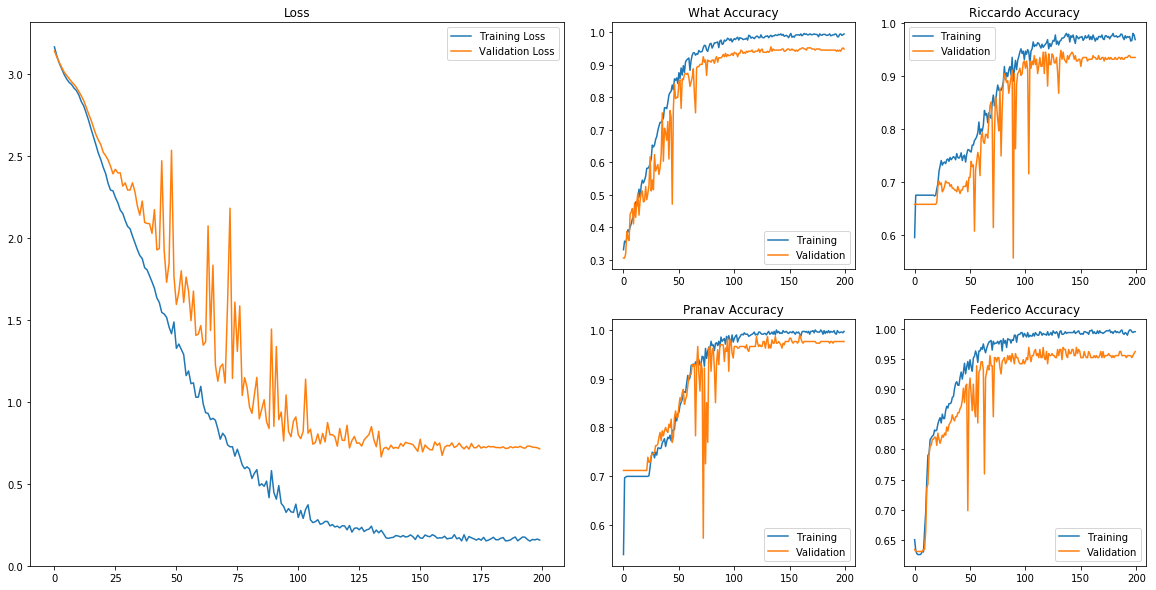

In [0]:
plt.figure(figsize=(20,10))

ax0 = plt.subplot2grid((2, 4), (0, 0), colspan=2, rowspan=2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.legend(['Training Loss', 'Validation Loss'])

ax1 = plt.subplot2grid((2, 4), (0, 2))
plt.plot(history.history['what_accuracy'])
plt.plot(history.history['val_what_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('What Accuracy')


ax1 = plt.subplot2grid((2, 4), (1, 2))
plt.plot(history.history['pranav_accuracy'])
plt.plot(history.history['val_pranav_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Pranav Accuracy')


ax1 = plt.subplot2grid((2, 4), (0, 3))
plt.plot(history.history['riccardo_accuracy'])
plt.plot(history.history['val_riccardo_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Riccardo Accuracy')


ax1 = plt.subplot2grid((2, 4), (1, 3))
plt.plot(history.history['federico_accuracy'])
plt.plot(history.history['val_federico_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Federico Accuracy')
plt.show()

In [0]:
model.evaluate(X_test, [y_what_test,y_is_ricc_test,y_is_fede_test, y_is_pk_test])

295/295 [==============================] - 1s 4ms/sample - loss: 0.7124 - what_loss: 0.2900 - riccardo_loss: 0.1933 - federico_loss: 0.1004 - pranav_loss: 0.1409 - what_accuracy: 0.9492 - riccardo_accuracy: 0.9356 - federico_accuracy: 0.9627 - pranav_accuracy: 0.9763


[0.7123758431208336,
 0.2899926,
 0.19328889,
 0.10041499,
 0.1408945,
 0.9491525,
 0.93559325,
 0.9627119,
 0.9762712]

In [0]:
model.save('cnn_model.h5')

In [0]:
def predict_nn(model, X, rate=88200, threshold=0.95):
    X = np.array(X).reshape(-1,rate,1).astype('float32')
    y = model.predict(X)

    what = list(map(lambda x: np.argmax(x) if x[np.argmax(x)] > 0.8 else -1, 
                  y[0]))
    what_what = {0:'Forse',1:'No',2:'Si',-1:'Non Capisco'}
    print(list(map(lambda x: what_what[x], what)))

    who = list(map(lambda x: np.argmax(x) if x[np.argmax(x)] > 0.8 else -1, 
                 np.hstack((y[1],y[2], y[3]))))
    person = {0:'Riccardo',1:'Federico',2:'Pranav',-1:'Unknown'}
    who_person = list(map(lambda x: person[x], who)) 
    print(who_person)

In [0]:
hk_si = pd.read_csv(path + 'extraTesting/Harshita_si.csv', header=None).drop(0, axis=1)
hk_no = pd.read_csv(path + 'extraTesting/Harshita_no.csv', header=None).drop(0,axis=1)
hk_forse = pd.read_csv(path + 'extraTesting/Harshita_forse.csv', header=None).drop(0,axis=1)
hk_caso = pd.read_csv(path + 'extraTesting/Harshita_caso.csv', header=None).drop(0,axis=1)

#hk_no = np.array(list(map(extract_feature, hk_no.values)))
#hk_si = np.array(list(map(extract_feature, hk_si.values)))
#hk_forse = np.array(list(map(extract_feature, hk_forse.values)))
#hk_caso = np.array(list(map(extract_feature, hk_caso.values)))

In [0]:
predict_nn(model, hk_no)

['Non Capisco', 'Non Capisco', 'No', 'No', 'No', 'Non Capisco']
['Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav']


In [0]:
predict_nn(model, hk_si)

['Forse', 'Forse', 'Si', 'Si']
['Pranav', 'Pranav', 'Pranav', 'Pranav']


In [0]:
predict_nn(model, hk_forse)

['Non Capisco', 'Non Capisco', 'Forse', 'Forse', 'Non Capisco', 'Non Capisco']
['Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav', 'Pranav']


In [0]:
predict_nn(model, hk_caso)

['No', 'No', 'Non Capisco', 'Non Capisco', 'Non Capisco', 'Non Capisco', 'Non Capisco']
['Pranav', 'Pranav', 'Pranav', 'Pranav', 'Unknown', 'Pranav', 'Pranav']


In [0]:
noemi = pd.read_csv(path+'Noemi.csv', header=None)

In [0]:
predict_nn(model, noemi.iloc[:,1:].values)

['Non Capisco', 'Non Capisco', 'Non Capisco']
['Unknown', 'Unknown', 'Pranav']
